<a href="https://colab.research.google.com/github/XZIPX/Fashion-MNIST-classifier/blob/main/TINYVGG_cloth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make CNN model for MNIST dataset

### Importing the libraries

In [1]:
import torch
from torch import nn

#Computer vision libraries
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

#Library for loading data
from torch.utils.data import DataLoader

from pathlib import Path

#For visualization
import matplotlib.pyplot as plt

import random
import numpy as np

In [2]:
#Setup device agnostic code
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

device

'cuda'

In [3]:
!nvidia-smi

Tue Aug 22 11:20:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Setting hyperparameters
BATCH_SIZE = 32
SEED = 42

###Downloading dataset

In [5]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10349414.60it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 166693.44it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3269431.20it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6437768.93it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



###Exploring the dataset

In [6]:
len(train_data), len(test_data)

(60000, 10000)

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

###Visualizing the dataset

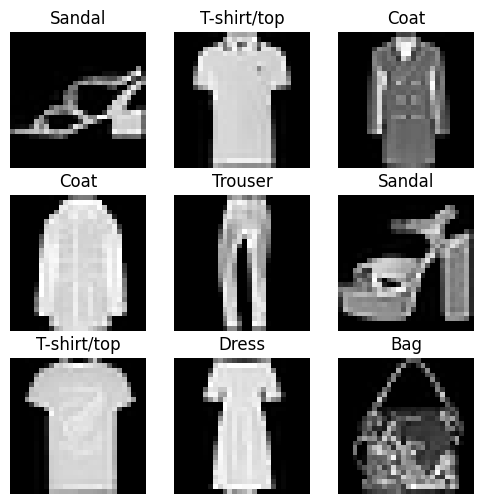

In [8]:
torch.manual_seed(SEED)
fig = plt.figure(figsize=(6, 6))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    rand_index = random.randint(0, len(train_data))
    img, label = train_data[rand_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);
plt.show()

###Loading dataset to Tensors

In [9]:
train_dataloader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [10]:
print(f"Number of batches for training: {len(train_dataloader)}")
print(f"Number of batches for testing: {len(test_dataloader)}")

Number of batches for training: 1875
Number of batches for testing: 313


###Building CNN model

In [11]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*49,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        x = self.classifier(x)
        return x

In [12]:
torch.manual_seed(SEED)
model = TinyVGG(
    input_shape = 1,
    hidden_units = 10,
    output_shape = len(class_names)
)
model

TinyVGG(
  (cnn_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

###Picking the loss and optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01)

###Functions for usage

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        return test_loss, test_acc

In [16]:
torch.manual_seed(SEED)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

###Training model

In [17]:
torch.manual_seed(SEED)

epochs = 5

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n")
    train_loss, train_accuracy = train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss, test_accuracy = test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")


Epoch: 0

Train Loss: 1.0378, Train Accuracy: 62.34%
Test Loss: 0.6251, Test Accuracy: 76.91%

Epoch: 1

Train Loss: 0.5493, Train Accuracy: 80.01%
Test Loss: 0.4982, Test Accuracy: 81.50%

Epoch: 2

Train Loss: 0.4557, Train Accuracy: 83.52%
Test Loss: 0.4403, Test Accuracy: 84.26%

Epoch: 3

Train Loss: 0.4133, Train Accuracy: 85.14%
Test Loss: 0.4124, Test Accuracy: 85.46%

Epoch: 4

Train Loss: 0.3865, Train Accuracy: 86.20%
Test Loss: 0.3982, Test Accuracy: 86.02%



In [22]:
numeric_train_losses = [loss.item() for loss in train_losses]
numeric_test_losses = [loss.item() for loss in test_losses]

###Plotting the results

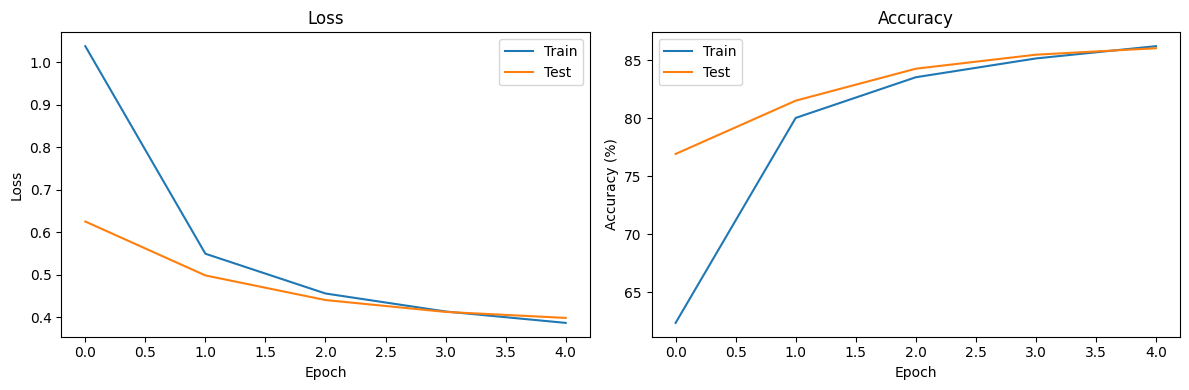

In [23]:
plt.figure(figsize=(12, 4))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(numeric_train_losses, label="Train")
plt.plot(numeric_test_losses, label="Test")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plotting Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'TinyVGG',
 'model_loss': 0.3982429802417755,
 'model_acc': 86.0223642172524}

###Saving the model

In [21]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "tinyvgg_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/tinyvgg_model.pth
